<a href="https://colab.research.google.com/github/msc-acse/acse-8-miniproject-sigmoid/blob/yeliu/Kuzishiji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 491kB 8.0MB/s 
     |████████████████████████████████| 215kB 44.5MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
path="/content/gdrive/My Drive/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

In [7]:
classmap

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [10]:
print(train_data.shape)

(60000, 28, 28)


In [0]:
mean_train = train_data.mean(axis=(0,1,2))/255
std_train = test_data.std(axis=(0,1,2))/255
mean_test = train_data.mean(axis=(0,1,2))/255
std_test = test_data.std(axis=(0,1,2))/255

In [29]:
print('train mean', mean_train )
print('train std', std_train )
print('test mean', mean_test )
print('test std', std_test )

train mean 0.19176214735894356
train std 0.3416117732991835
test mean 0.19176214735894356
test std 0.3416117732991835


In [0]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train, std=std_train),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test, std=std_test),
])

In [13]:
type(train_data)
type(train_labels)

numpy.ndarray

### Split

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [0]:
X_train, y_train = torch.from_numpy(train_data)[indices[0]], torch.from_numpy(np.array(train_labels)[indices[0]])
X_val, y_val = torch.from_numpy(train_data)[indices[1]], torch.from_numpy(np.array(train_labels)[indices[1]])
X_test = torch.from_numpy(test_data)

In [0]:
def Normlization(X):
    X /= 255. 
    mean = X.numpy().mean(axis=(0,1,2))
    std = X.numpy().std(axis=(0,1,2))
    X -= mean
    X /= std
    return X

In [0]:
X_train = Normlization(X_train.float())
X_val = Normlization(X_val.float())
X_test = Normlization(X_test.float())

In [23]:
# Check if 0-mean and 1-std after normlization
print("train mean after normlization:", X_train.numpy().mean(axis=(0,1,2)))
print("train std after normlization:", X_train.numpy().std(axis=(0,1,2)))
print(" ")
print("val mean after normlization:", X_val.numpy().mean(axis=(0,1,2)))
print("val std after normlization:", X_val.numpy().std(axis=(0,1,2)))
print(" ")
print("test mean after normlization:", X_test.numpy().mean(axis=(0,1,2)))
print("test std after normlization:", X_test.numpy().std(axis=(0,1,2)))

train mean after normlization: 8.76919e-08
train std after normlization: 1.0000007
 
val mean after normlization: 8.9619434e-08
val std after normlization: 1.0000002
 
test mean after normlization: -7.346163e-08
test std after normlization: 0.9999999


## Model

In [27]:
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - 3x32x32
    -----Convolution Layers--------
    C1 - 6@28x28 (5x5 kernel)
    S2 - 6@14x14 (2x2 kernel, stride 2) Pool layer Subsampling
    C3 - 16@10x10 (5x5 kernel)
    S4 - 16@5x5 (2x2 kernel, stride 2) Pool layer Subsampling
    -----Full Connected Layers-------
    C5 - 1024@1x1 (5x5 kernel)
    F6 - 84
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=5, padding = 2, stride=1)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('relu2', nn.ReLU()),
            ('c3', nn.Conv2d(6, 16, kernel_size=5)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('relu4', nn.ReLU())
             ]))

        self.fc = nn.Sequential(OrderedDict([
            ('c5', nn.Linear(16*5*5, 120)),
            ('relu5', nn.ReLU()),
            ('dp1',nn.Dropout(0.5)),
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('dp2',nn.Dropout(0.5)),
            ('f7', nn.Linear(84, 10))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, output.size(1)*output.size(2))
        output = self.fc(output)
        return output
  
x = torch.randn((1, 1, 32, 32))
model = LeNet5()
y = model(x)
print(y)

RuntimeError: ignored

In [53]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 256)
    self.output = nn.Linear(256, 10)
    self.act = nn.ReLU()
    self.dp = nn.Dropout(0.5)
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.dp(x)
    x = self.act(self.f6(x))
    x = self.dp(x)
    return self.output(x)
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)

tensor([[ 0.0972,  0.1555, -0.1382,  0.0272, -0.0528, -0.1505,  0.0065, -0.0545,
          0.0160, -0.0984]], grad_fn=<AddmmBackward>)


In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30
weights_set = [0.0, 1e-3, 1e-4, 1e-5]

In [0]:
class SupervisedLearning:
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 normalise=True,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=30):
      
      self.device = device
      
      self.X = X
      self.y = y
      
      self.model = model.to(self.device)
      self.optimiser = optimiser
      self.loss_function = loss_function
      
      self.X_train = None
      self.X_val = None
      
      self.y_train = None
      self.y_val = None
      
      self.train_transform = train_transform
      self.val_transform = val_transform
      
      assert(batch_size > 0 and batch_size < int(0.1 * X.size()[0]))
      self.batch_size = batch_size
      assert(test_batch_size > 0 and test_batch_size < int(0.1 * X.size()[0]))
      self.test_batch_size = test_batch_size
      self.n_epochs = n_epochs
      self.seed = seed

      self.trained_full=False
      
    def split_data(self):
      sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
      sss.get_n_splits(self.X, self.y)

      for train_index, val_index in sss.split(self.X, self.y):
        self.X_train, self.X_val = self.X[train_index], self.X[val_index]
        self.y_train, self.y_val = self.y[train_index], self.y[val_index]
        
      return None
      
      
      
    def train(self, train_data_loader):
      self.model.train()                     # set model to train mode
      
      train_loss, train_accuracy = 0., 0.
      
      for Xtr, ytr in train_data_loader:# X and y are data inside a batch specified
                                        # at train_data_loader
        Xtr = Xtr.to(self.device)
        ytr = ytr.to(self.device)
        
        optimiser.zero_grad()           # reset gradients
        zn = model(Xtr)                 # perform forward pass
        
        loss = loss_function(zn, ytr)   # compute loss value over batch
        loss.backward()                 # perform backward pass
        train_loss += (loss * Xtr.size()[0]).detach().cpu().numpy()
      
        y_pred = F.log_softmax(zn, dim=1).max(1)[1]
        train_accuracy += accuracy_score(ytr.cpu().numpy(), y_pred.detach().cpu().numpy())*Xtr.size()[0]
        
        optimiser.step()               # optimisation step
        
      return train_loss/len(train_data_loader.dataset), train_accuracy/len(train_data_loader.dataset)
    
    
    
    def validate(self, val_data_loader):
      self.model.eval()                     # set model to evaluation mode
      
      validation_loss, validation_accuracy = 0., 0.
      
      for Xv, yv in val_data_loader:
        with torch.no_grad():
          
          Xv, yv = Xv.to(self.device), yv.to(self.device)
          
          zn = model(Xv)
          loss = loss_function(zn, yv)
          validation_loss += (loss * Xv.size(0)).detach().cpu().numpy()
          
          y_pred = F.log_softmax(zn, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(yv.cpu().numpy(), y_pred.detach().cpu().numpy())*Xv.size(0)

            
      return validation_loss/len(val_data_loader.dataset), validation_accuracy/len(val_data_loader.dataset)
        
      
    
    def train_model(self, train_full=False, plot_loss=True):
      # set seed
      set_seed(int(self.seed))
      
      
      if train_full: # train with full data (train + validation)
        # create dataloaders
        train_dataset = CustomTensorDataset(self.X, self.y, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = train_loss.item()
              logs['val_' + 'accuracy'] = train_accuracy.item()
              liveloss.update(logs)
              liveloss.draw()
              
        self.trained_full=True

      else:
        # split data
        self.split_data()
        
        # create dataloaders
        train_dataset = CustomTensorDataset(self.X_train, self.y_train, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataset = CustomTensorDataset(self.X_val, self.y_val, transform=self.val_transform)
        val_data_loader = DataLoader(val_dataset, batch_size=self.test_batch_size, shuffle=True)
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
              logs = {}
              train_loss, train_accuracy = self.train(train_data_loader)
              val_loss, val_accuracy = self.validate(val_data_loader)

              if plot_loss:
                logs['' + 'log loss'] = train_loss.item()
                logs['' + 'accuracy'] = train_accuracy.item()
                logs['val_' + 'log loss'] = val_loss.item()
                logs['val_' + 'accuracy'] = val_accuracy.item() # liveloss wants it plotted
                liveloss.update(logs)
                liveloss.draw() 

        self.trained_full=False
              
      return None
            
            
    def evaluate_batch(self, X_test, y_test, confusion_matrix=True, test_transform=None):
      """
      This method performs the same as validate but also returns all predictions on a given dataset
      for a trained model.
      """
      self.model.eval()
      
      test_dataset = CustomTensorDataset(X_test, y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=True)
      
      ys, y_preds = [], []
      
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = model(X)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds, ys =  np.concatenate(y_preds, 0),  np.concatenate(ys, 0)
      
      test_loss, test_accuracy = self.validate(test_data_loader)
      
      if confusion_matrix:
        cm = ConfusionMatrix(actual_vector=ys, predict_vector=y_preds)
        print(cm)
        
        
      return y_preds, ys, test_loss, test_accuracy

In [0]:
km_train = TensorDataset(X_train, y_train.long())
km_validate = TensorDataset(X_val, y_val.long())
#cifar_test = TensorDataset(X_test, y_test.long())

In [0]:
def train(model, optimizer, criterion, data_loader, plot=True):
    """Train function, the plot arguement is used to decide whether plot or not """
    model.train()
    train_loss, train_accuracy = 0, 0
    iii = 0
    
    if plot:
      fig, axarr = plt.subplots(1, 5, figsize=(10, 2))
      axarr = axarr.flatten()
    
    for X, y in data_loader:
        if plot:
           
            # Show 5 input images to do the sanity check
            while iii < 5:
                print(X.shape)
                X_show = X[iii]
                axarr[iii].imshow(X_show)
                #axarr[iii].set_title(classes[y[iii]])
                iii += 1
             
      
        X = X.view(-1, 1, 28, 28)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
def train_model(weight_decay=0):
  """The train function which takes the weight-decay as the argument """
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay )
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(km_train, batch_size=batch_size, shuffle=True, num_workers=4)
  validation_loader = DataLoader(km_validate, batch_size=test_batch_size, shuffle=False, num_workers=4)
  #test_loader = DataLoader(cifar_test, batch_size=test_batch_size, shuffle=False, num_workers=4)
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()
      liveloss.update(logs)
      liveloss.draw()

  #test_loss, test_accuracy = validate(model, criterion, test_loader)    
  #print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
  print("")
      
  return model

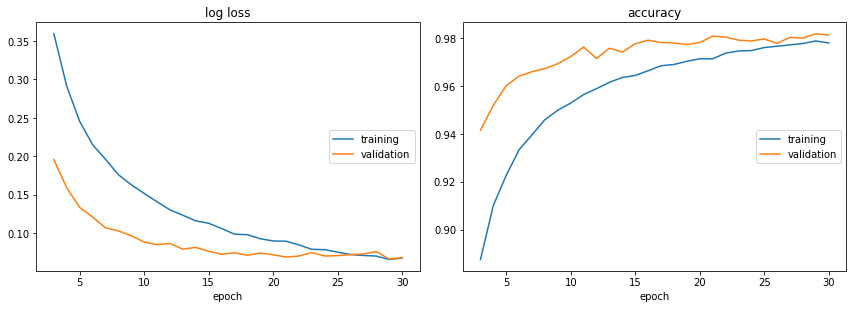

log loss:
training   (min:    0.066, max:    1.167, cur:    0.068)
validation (min:    0.066, max:    0.447, cur:    0.068)

accuracy:
training   (min:    0.604, max:    0.979, cur:    0.978)
validation (min:    0.863, max:    0.982, cur:    0.981)


NameError: ignored

In [47]:
model = train_model()

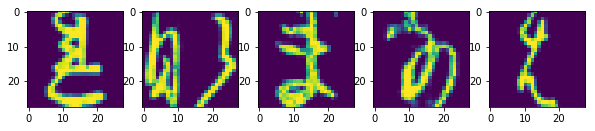

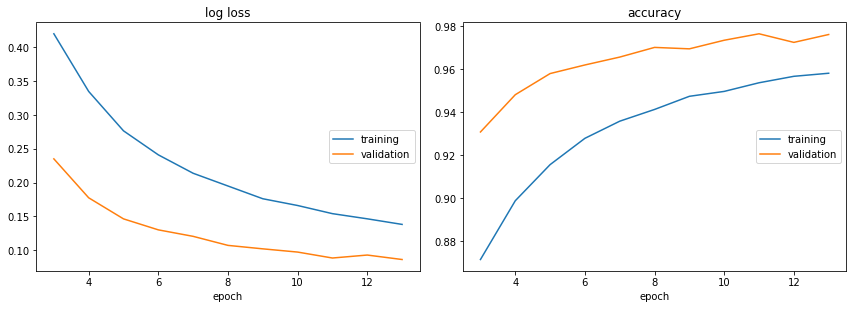

log loss:
training   (min:    0.138, max:    1.352, cur:    0.138)
validation (min:    0.086, max:    0.565, cur:    0.086)

accuracy:
training   (min:    0.535, max:    0.958, cur:    0.958)
validation (min:    0.828, max:    0.977, cur:    0.976)
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
torch.Size([64, 28, 28])


In [0]:
model = train_model()